## Analyzing Aggravated Burglaries in Davidson County

### Part 1 - Data Gathering using APIs

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents () that were reported during the nine month period from January 1, 2022 through September 30, 2022. (Hint: Check out the API Docs (https://dev.socrata.com/foundry/data.nashville.gov/2u6v-ujjs) to see how to narrow down the response to just the desired results).

In [50]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
from shapely.geometry import Point
import shapely
import numpy as np
from scipy.stats import poisson
from scipy.stats import chi2
from ipywidgets import interact, FloatSlider, IntSlider
import statsmodels.api as sm
import statsmodels.formula.api as smf
from shapely.ops import unary_union

Reading the API, I decided to use NIBRS code (https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes). For burglary it is 220.

The 'offense description' isn't always consistent. Will have to check which ones have 'aggravated' in there:
https://data.nashville.gov/resource/2u6v-ujjs.json?offense_nibrs=220

The code below just connects to the API and gets the requested type (burglary/breaking and entering)

In [2]:
endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.json'

params = {
    '$where' : "incident_reported between '2022-01-01T00:00:00' and '2022-09-30T23:59:59'",
    'offense_nibrs' : 220,
    '$limit' : 5000
}

# turns out it would also work with '$q' : 'BURGLARY- AGGRAVATED'
# but I was worried about typos or abbreviations

response = requests.get(endpoint, params = params)
response


<Response [200]>

In [3]:
# to check the constracted url with the params
response.url

'https://data.nashville.gov/resource/2u6v-ujjs.json?%24where=incident_reported+between+%272022-01-01T00%3A00%3A00%27+and+%272022-09-30T23%3A59%3A59%27&offense_nibrs=220&%24limit=5000'

In [4]:
len(response.json())

3537

In [5]:
incidents_df = pd.DataFrame(response.json())

In [6]:
# I used this before I figured out how to do it with regex
# incidents_df[incidents_df['offense_description'].str.upper().str.find('AGGRAVATED') != -1]

The below code is to get all the burglaries that contain at least agg (shorthand for AGGRAVATED). Comparing it to the output with my previous code I found out that the word AGGRAVATED was never actually abbreviated in the file.

In [7]:
incidents_df = incidents_df[incidents_df['offense_description'].str.match(r'.+[aA][gG][gG].+') == True]

In [8]:
# this line only gives the unique values;
# incidents_df['offense_description'].unique()

incidents_df['offense_description'].value_counts()

BURGLARY- AGGRAVATED                         1369
BURGLARY - AGGRAVATED                         338
BURGLARY - ESPECIALLY AGGRAVATED                9
Burglary - Aggravated - Acting in Concert       4
BURGLARY - AGGRAVATED - ACTING IN CONCERT       4
Name: offense_description, dtype: int64

2. Using the 2020 American Community Survey API (https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37.

First off, loading my key for the census data API!

with open('../keys.json') as fi:
    credentials = json.load(fi)

api_key = credentials['api_key']

Found out later the api_key is ont even needed!

> note: the documentation for how to construct the API request (for detailed tables) is found here: https://api.census.gov/data/2020/acs/acs5/examples.html

In [9]:
# my code below had all in a single string
# endpoint = f'https://api.census.gov/data/2020/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:47&in=county:037&key={api_key}'
# response = requests.get(endpoint)
# response

# better, more readable:
URL = 'https://api.census.gov/data/2020/acs/acs5'

params = {
    'get': 'NAME,B01001_001E',
    'for': 'tract:*',
    'in': 'state:47 county:037'
}

response = requests.get(URL, params = params)

In my orig. code I just loaded the whole dataframe:

```pop_df = pd.DataFrame(response.json())```

And then reformatted it:

```
pop_df = (
    pop_df
    .rename(columns=pop_df.iloc[0])
    .drop(pop_df.index[0])
    .rename(columns={'B01001_001E':'population'})
)
```

In [10]:
# this solution is more elegant; taking first row as names directly
pop_df = (
    pd.DataFrame(response.json()[1:], 
                columns = response.json()[0])
        .rename(columns={'B01001_001E':'population'})
)

Similar but different, Subject Tables now. 

In [11]:
# same coments as above
# endpoint = f'https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S1901_C01_012E&for=tract:*&in=state:47&in=county:037&key={api_key}'

# response = requests.get(endpoint)
# response

# med_income_df = pd.DataFrame(response.json())

# med_income_df = (
#    med_income_df
#    .rename(columns=med_income_df.iloc[0])
#    .drop(med_income_df.index[0])
#    .rename(columns={'S1901_C01_012E':'median_income'})
#)

URL = 'https://api.census.gov/data/2020/acs/acs5/subject'

params = {
    'get': 'NAME,S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037'
}

response = requests.get(URL, params = params)

med_income_df = (
    pd.DataFrame(response.json()[1:], 
                columns = response.json()[0])
        .rename(columns={'S1901_C01_012E':'median_income'})
)


Did a .head() and .count() command to make sure both tables have the same length (as they should, 174); after the merge below the number was the same as well.

In [12]:
pop_med_income_df = pd.merge(pop_df, med_income_df, "inner", on=['NAME', 'state', 'county', 'tract'])

### Part 2 - Spatial Joining and Data Merging

3. Download the 2020 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred.

In [13]:
tract_geo = gpd.read_file('../data/tl_2020_47_tract/tl_2020_47_tract.shp')

# only interested in Davidson Co.
tract_geo = tract_geo[tract_geo['COUNTYFP'] == '037']

Note: at first I tried to use the 'mapped_location' to turn it into a point. However, both doing a list comprehension like this:

`x['coordinates'] for x in incidents_df['mapped_location'])`

or, expanding the dictionary first with:

` incidents_df.mapped_location.apply(pd.Series)['coordinates']`

and then trying to unpack the remaining list with a lambda-function

` incidents_df['lnglat'].apply(lambda x: x[0])`

none of it was working. The error was 'float' is not subsciptible. Instructor Michael helped me figure out that some rows had NaNs, which is what caused that error. So, the code commented below works, but was abandoned:

```
incidents_df['lat'] = (
     [x['coordinates'][0] 
      if x is not np.nan 
      else None 
      for x in incidents_df['mapped_location']]    
)
```

In [14]:
# note: at some point we decided to drop duplicates here, but it's perhaps more elegant to just use nunique later
# incidents_df = incidents_df.drop_duplicates(subset='incident_number')

incidents_df['geometry'] = gpd.points_from_xy(incidents_df['longitude'], incidents_df['latitude'])

incidents_geo = gpd.GeoDataFrame(incidents_df,
                                crs = tract_geo.crs,
                                geometry = incidents_df['geometry'])

# has to be a right join so that we keep all tracts even with no burglaries within
incidents_by_tract = gpd.sjoin(incidents_geo,
                                tract_geo,
                                how='right',
                                predicate = 'within')

In [15]:
#incidents_by_tract.info()

4. Aggregate the data by census tract. Warning: each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents. Which census tract had the highest number of burglaries? Which census tract had the highest number of burglaries per 1000 residents? Note: Make sure that you keep all census tracts, not just those that have had a burglary.

> highest number of burglaries -> tract # 143; to answer the other question, see point 5. as we need to get the population in

In [16]:
# If wanting to see the name of census tract
# incidents_by_tract.groupby('NAMELSAD')['incident_number'].nunique().reset_index(name = 'num_burglaries')

# note: I originally kept the whole table, but since we're not interested in other information, it's better to just save it back
incidents_by_tract = (
    incidents_by_tract
    .groupby('TRACTCE')
    ['incident_number']
    .nunique()
    .reset_index(name = 'num_burglaries')
)
incidents_by_tract

,TRACTCE,num_burglaries
0,010103,4
1,010104,7
2,010105,7
3,010106,8
4,010201,6
...,...,...
169,019502,11
170,019503,8
171,019600,10
172,980100,0


In [17]:
incidents_by_tract.sort_values('num_burglaries')

,TRACTCE,num_burglaries
173,980200,0
116,017902,0
113,017702,0
7,010302,0
6,010301,0
...,...,...
146,019003,22
54,014200,28
95,016000,31
98,016300,37


5. Merge in the census data that you gathered in question 2. Remove any rows that have zero population or negative median income values.

In [18]:
incidents_by_tract = pd.merge(
    left = incidents_by_tract,
    right = (pop_med_income_df[['tract', 'population', 'median_income']]
                .rename(columns = {'tract': 'TRACTCE'})
            ),
    how='right',
    on='TRACTCE'
)

In [19]:
incidents_by_tract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TRACTCE         174 non-null    object
 1   num_burglaries  174 non-null    int64 
 2   population      174 non-null    object
 3   median_income   174 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.8+ KB


In [20]:
incidents_by_tract['population'] = incidents_by_tract['population'].astype(int)
incidents_by_tract['median_income'] = incidents_by_tract['median_income'].astype(int)

In [21]:
# code below to get rid of zero population and negative med values
incidents_by_tract = incidents_by_tract[incidents_by_tract['population'] > 0] 
incidents_by_tract = incidents_by_tract[incidents_by_tract['median_income'] >= 0]

In [22]:
#incidents_by_tract.shape
incidents_by_tract

,TRACTCE,num_burglaries,population,median_income
0,019004,20,4470,44001
1,019007,6,2904,48485
2,019008,1,6005,50512
3,019105,9,5707,48271
4,019106,6,4336,65323
...,...,...,...,...
169,018901,6,3280,47500
170,018902,2,2704,75286
171,018904,12,3410,61750
172,018905,7,3292,65960


In [23]:
# new column to have number of incidents per population
incidents_by_tract['burglaries_per_thousand'] = incidents_by_tract['num_burglaries'] / incidents_by_tract['population'] * 1000.0

In [24]:
#incidents_by_tract.sort_values('burglaries_per_thousand', ascending=False)
incidents_by_tract.nlargest(5, 'burglaries_per_thousand')

,TRACTCE,num_burglaries,population,median_income,burglaries_per_thousand
82,014300,41,1617,40425,25.355597
125,016300,37,2689,54886,13.759762
81,014200,28,2072,24237,13.513514
122,016000,31,2570,21868,12.062257
63,012600,21,2152,56667,9.758364


> same answer as before, the tract with most burglaries per population is 143, the second and third change

### Some choropleths

code adapted from notebook by our instructor Michael

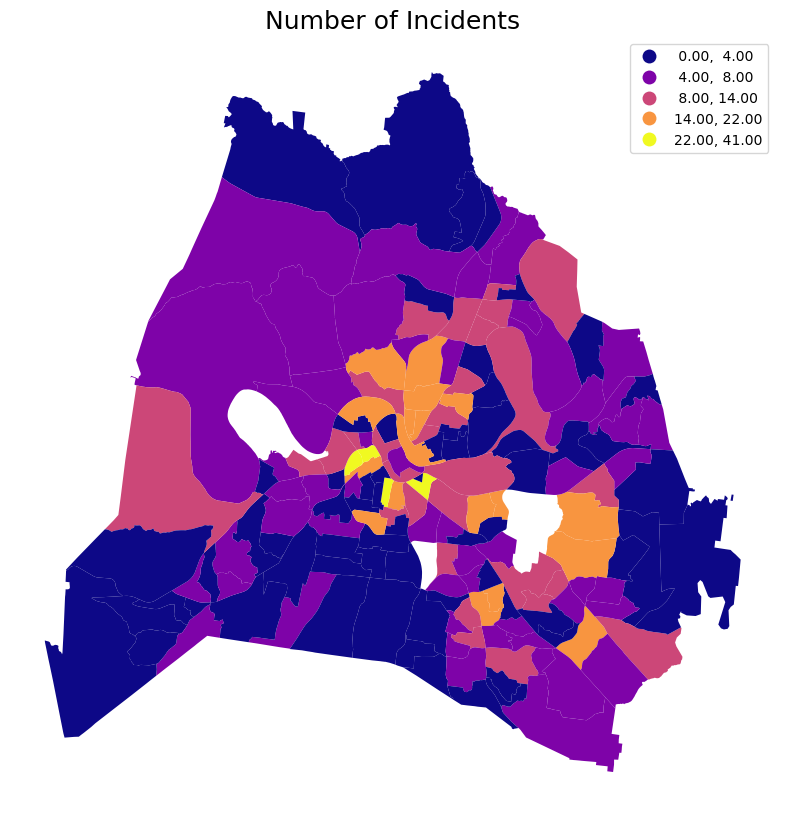

In [25]:
fix, ax = plt.subplots(figsize = (10,10))

(
    pd.merge(left = tract_geo,
         right = incidents_by_tract)
    .plot(column = 'num_burglaries',
          ax = ax,
          scheme = 'NaturalBreaks',
          cmap='plasma',
          legend = True)
)
plt.title('Number of Incidents', fontsize = 18)
plt.axis('off');

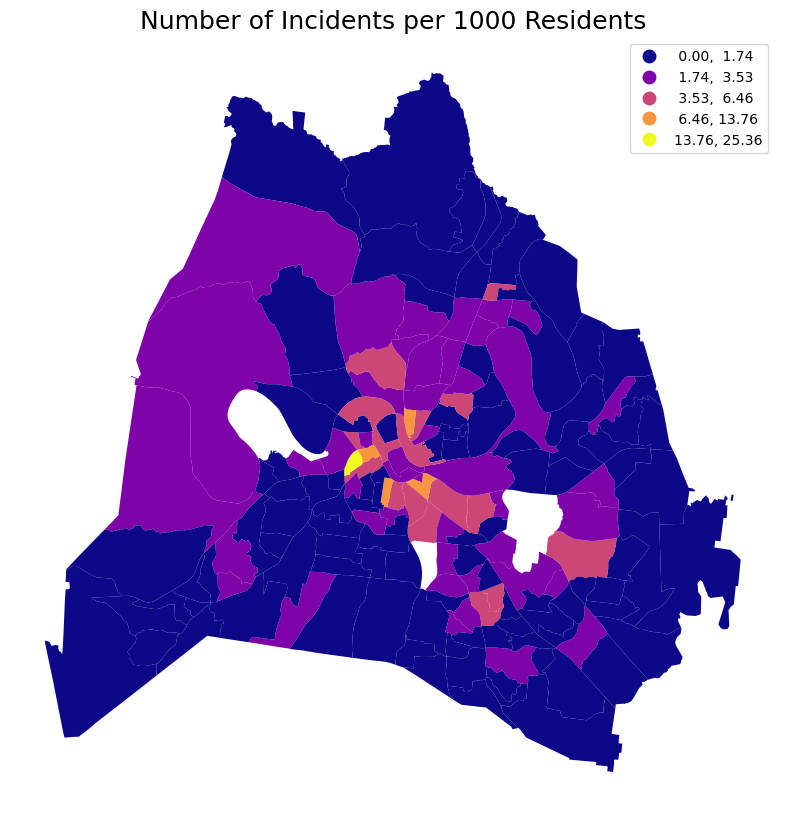

In [26]:
fix, ax = plt.subplots(figsize = (10,10))

(
    pd.merge(left = tract_geo,
             right = (incidents_by_tract
                      .assign(incident_rate = 1000 * incidents_by_tract['num_burglaries'] / incidents_by_tract['population'])
                     )
            )
    .plot(column = 'incident_rate',
          ax = ax,
          scheme = 'NaturalBreaks',
          cmap='plasma',
         legend = True)
)
plt.title('Number of Incidents per 1000 Residents', fontsize = 18)
plt.axis('off');

### Part 3 - Statistical Modeling

6. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. Start with some EDA to look at the relationship between median income and number of aggravated burglaries.

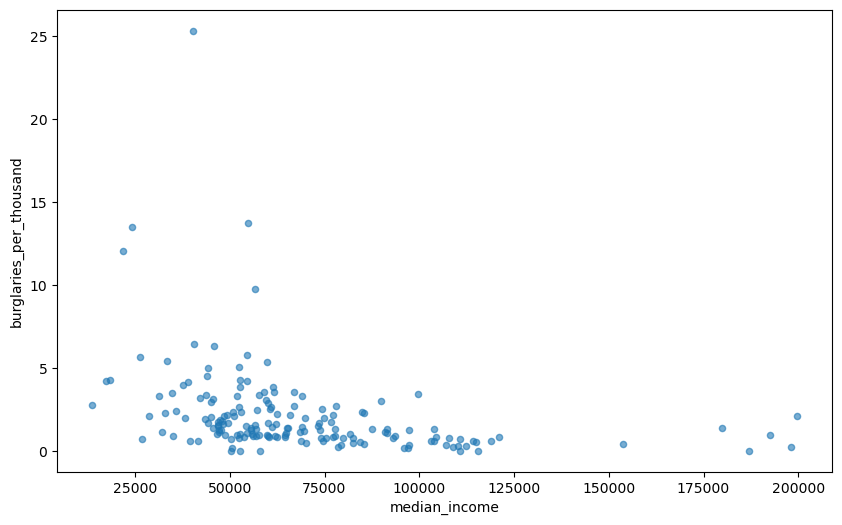

In [27]:
incidents_by_tract.plot(
    kind='scatter',
    x='median_income',
    y='burglaries_per_thousand',
    alpha = 0.6,
    figsize = (10,6));

There appears to be a downward trend. I.e. with higher median income, there appears to be less aggravated burglaries.

NOTE: When combining, since census tracts are different size, it might make sense to do a weighted average burglaries per thousand instead of averaging the individual values.

In [28]:
ta_summary = (
    incidents_by_tract
    .assign(group = pd.qcut(incidents_by_tract['median_income'], q = 15))
    .groupby('group')
    .agg({'median_income': 'mean',
         'burglaries_per_thousand': 'mean',
         'num_burglaries': 'sum',
         'population': 'sum'})
    .reset_index()
)
ta_summary['bpt'] = ta_summary['num_burglaries'] / ta_summary['population'] * 1000
ta_summary

,group,median_income,burglaries_per_thousand,num_burglaries,population,bpt
0,"(13749.999, 33861.733]",25589.083333,4.777840,160,39437,4.057104
1,"(33861.733, 42786.533]",38605.636364,4.807130,136,37757,3.601981
2,"(42786.533, 46749.6]",44856.000000,3.014478,131,46445,2.820540
3,"(46749.6, 49190.267]",47724.750000,1.563675,78,50644,1.540163
4,"(49190.267, 52458.333]",51216.545455,1.777458,83,52022,1.595479
5,"(52458.333, 55249.6]",53663.000000,3.505343,127,44389,2.861069
6,"(55249.6, 58031.4]",56640.545455,2.251579,72,38589,1.865817
7,"(58031.4, 61155.933]",59977.666667,2.139348,107,49885,2.144933
8,"(61155.933, 65577.8]",63351.454545,1.677049,66,44082,1.497210
9,"(65577.8, 73413.333]",68933.818182,1.805275,70,42380,1.651723


Similar trends observed as described above

## Models

7. Fit a Poisson regression model with target variable the rate of burglaries per census tract and with predictor the median income. Offset using the log of the population so that we are looking at the rate of burglaries per population instead of the number of burglaries. How can you interpret the meaning of the output?

In [29]:
poisson_model = smf.glm('num_burglaries ~ I(median_income / 1000)',
                        offset = np.log(incidents_by_tract['population'] / 1000),
                        family = sm.families.Poisson(),
                        data = incidents_by_tract).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_burglaries   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -687.00
Date:                Fri, 17 Feb 2023   Deviance:                       783.09
Time:                        16:47:58   Pearson chi2:                 1.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7809
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.8035      0.081     22.341      0.000       1.645       1.962
I(median_income / 1000)    -0.0194      0.001    -14.490      0.000      -0.022      -0.017
===========================================================================================
"""

After offsetting for population, and deciding to divide the median income by 1000 (otherwise the factor of changing by a single $ is miniscule) the model estimates that:

$$\text{average number of burglaries} = e^{-1.8035 -0.0194(\text{median income in thousands of UDS)}}$$

In other words, for each $1000 change in median income, the average number of burglaries is predicted to decrease by exp(-0.0194), aka a factor of 0.98078 (decrease by 1.92%)

In [30]:
# using the summary from before (the one with quantiles) to check how good the fit does
ta_summary['fitted'] = poisson_model.predict(ta_summary)

ta_summary

,group,median_income,burglaries_per_thousand,num_burglaries,population,bpt,fitted
0,"(13749.999, 33861.733]",25589.083333,4.777840,160,39437,4.057104,3.695805
1,"(33861.733, 42786.533]",38605.636364,4.807130,136,37757,3.601981,2.871188
2,"(42786.533, 46749.6]",44856.000000,3.014478,131,46445,2.820540,2.543375
3,"(46749.6, 49190.267]",47724.750000,1.563675,78,50644,1.540163,2.405720
4,"(49190.267, 52458.333]",51216.545455,1.777458,83,52022,1.595479,2.248181
5,"(52458.333, 55249.6]",53663.000000,3.505343,127,44389,2.861069,2.143991
6,"(55249.6, 58031.4]",56640.545455,2.251579,72,38589,1.865817,2.023677
7,"(58031.4, 61155.933]",59977.666667,2.139348,107,49885,2.144933,1.896838
8,"(61155.933, 65577.8]",63351.454545,1.677049,66,44082,1.497210,1.776685
9,"(65577.8, 73413.333]",68933.818182,1.805275,70,42380,1.651723,1.594360


**note**: the fitted quantity has to be compared with burglary per capita (also same for the graph below). That is because we **offset** for population in our fit!!!

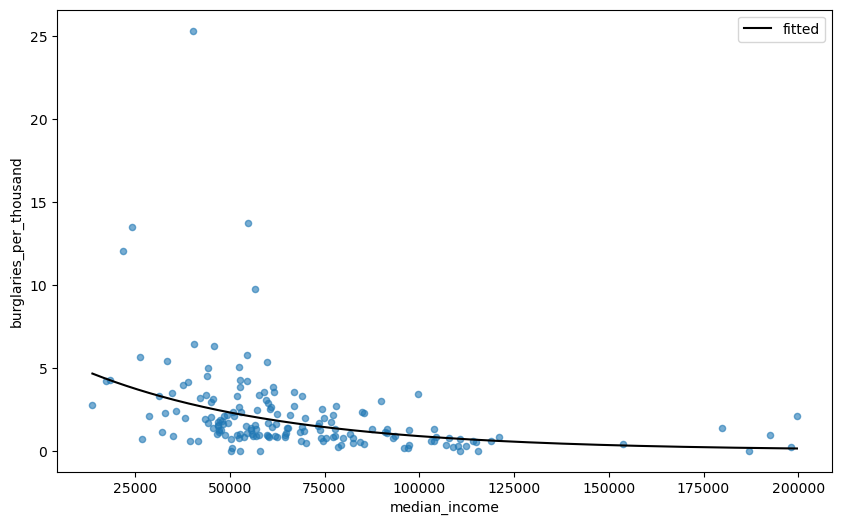

In [31]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(
        start = incidents_by_tract['median_income'].min(),
        stop = incidents_by_tract['median_income'].max(),
        num = 250)
})
fit_df['fitted'] = poisson_model.predict(fit_df)

ax = incidents_by_tract.plot(x = 'median_income',
                     y = 'burglaries_per_thousand',
                     kind = 'scatter',
                     figsize = (10,6),
                     alpha = 0.6)

fit_df.plot(x = 'median_income',
            y = 'fitted',
            color = 'black',
            ax = ax);

After checking the probabilities in the graph below, I decided to adjust the parameters and have the probabilities be estimated per 1000 people (otherwise the graph is far too squished towards 0).

In [32]:
@interact(median_income = IntSlider(value = 100000, min = incidents_by_tract['median_income'].min(), max = incidents_by_tract['median_income'].max()))
def fit_plot(median_income):
    
    mu = np.exp(poisson_model.params['Intercept'] + \
                (median_income/1000) * poisson_model.params['I(median_income / 1000)'])
    x = np.arange(start = 0, stop = 20, step = 1)
    y = poisson.pmf(x, mu = mu)

    plt.figure(figsize = (10,5))
    plt.bar(x, y, edgecolor = 'black')
    plt.xticks(x)
    plt.xlabel('Number of Burglaries per 1000 people')
    plt.ylabel('Probability')
    plt.title(f'Estimated Distribution of Number of Burglaries per 1000 people\nmedian_income = {median_income} \n$\mu$={round(mu, 3)}');

interactive(children=(IntSlider(value=100000, description='median_income', max=199643, min=13750), Output()), …

Note (by Michael): a Poisson distribution has the property that the mean and variance are identical.

The code below shows it is overdispersed, so our standard errors will be too narrow - leading into trying the negative binomial!

In [33]:
((incidents_by_tract['num_burglaries'] - poisson_model.fittedvalues)**2 / poisson_model.fittedvalues).mean()

6.940690449434928

### Trying out a negative binomial model

Since our model appears to be overdispersed, we might be better off using a negative binomial model.

8. Bonus: Try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/). How does this model compare to the Poisson model?

NOTE: I originally followed the instructions, but after our instructor Michael presented us with his solution, I thought it was better structured. So the code below is an amalgamation, but mostly follows Michael's example.

In [34]:
nb_model = smf.glm('num_burglaries ~ I(median_income / 1000)',
                    offset= np.log(incidents_by_tract['population'] / 1000),
                    family=sm.families.NegativeBinomial(),
                    data = incidents_by_tract).fit()

nb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_burglaries   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -520.02
Date:                Fri, 17 Feb 2023   Deviance:                       110.23
Time:                        16:47:59   Pearson chi2:                     171.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.1747
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.6719      0.209      8.016      0.000       1.263       2.081
I(median_income / 1000)    -0.0154      0.003     -5.259      0.000      -0.021      -0.010
===========================================================================================
"""

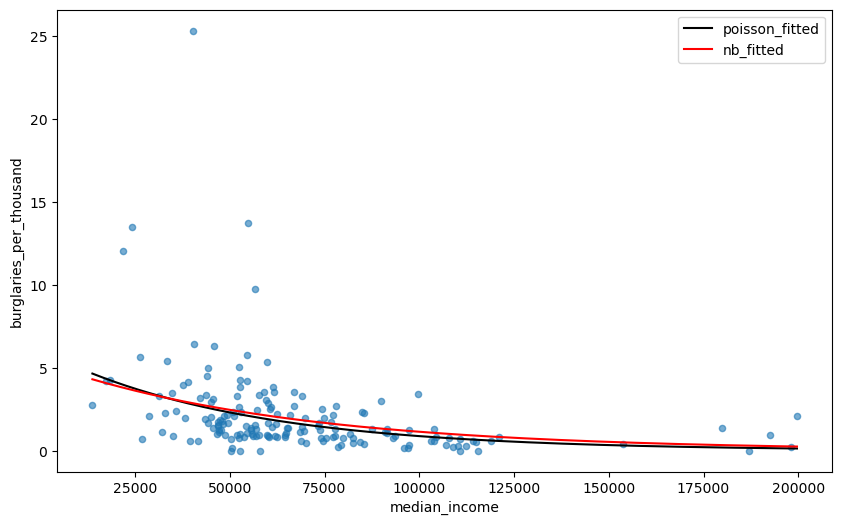

In [35]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(
        start = incidents_by_tract['median_income'].min(),
        stop = incidents_by_tract['median_income'].max(),
        num = 250)
})
fit_df['poisson_fitted'] = poisson_model.predict(fit_df)
fit_df['nb_fitted'] = nb_model.predict(fit_df)

ax = incidents_by_tract.plot(x = 'median_income',
                     y = 'burglaries_per_thousand',
                     kind = 'scatter',
                     figsize = (10,6),
                     alpha = 0.6)
                     
fit_df.plot(x = 'median_income',
            y = 'poisson_fitted',
            color = 'black',
            ax = ax)
            
fit_df.plot(x = 'median_income',
            y = 'nb_fitted',
            color = 'red',
            ax = ax);

In [36]:
ta_summary['fit_nb'] = nb_model.predict(ta_summary)
ta_summary

,group,median_income,burglaries_per_thousand,num_burglaries,population,bpt,fitted,fit_nb
0,"(13749.999, 33861.733]",25589.083333,4.777840,160,39437,4.057104,3.695805,3.584887
1,"(33861.733, 42786.533]",38605.636364,4.807130,136,37757,3.601981,2.871188,2.932119
2,"(42786.533, 46749.6]",44856.000000,3.014478,131,46445,2.820540,2.543375,2.662344
3,"(46749.6, 49190.267]",47724.750000,1.563675,78,50644,1.540163,2.405720,2.546979
4,"(49190.267, 52458.333]",51216.545455,1.777458,83,52022,1.595479,2.248181,2.413282
5,"(52458.333, 55249.6]",53663.000000,3.505343,127,44389,2.861069,2.143991,2.323813
6,"(55249.6, 58031.4]",56640.545455,2.251579,72,38589,1.865817,2.023677,2.219385
7,"(58031.4, 61155.933]",59977.666667,2.139348,107,49885,2.144933,1.896838,2.107912
8,"(61155.933, 65577.8]",63351.454545,1.677049,66,44082,1.497210,1.776685,2.000906
9,"(65577.8, 73413.333]",68933.818182,1.805275,70,42380,1.651723,1.594360,1.835647


That is just using a basic negative binomial. Following the tutorial, the idea is:

The model we'll use will assume that the variance $\sigma$ is equal to 

$$\sigma^2 = \mu + \alpha\cdot\mu^2$$

for some $\alpha$.

So $\alpha\cdot\mu = \frac{(\sigma^2 - \mu)}{\mu}$. We'll estimate $\alpha$ by fitting an auxiliary model.

In [37]:
poisson_model_aux = smf.glm('num_burglaries ~ I(median_income / 1000)',
                       offset= np.log(incidents_by_tract['population'] / 1000),
                       family=sm.families.Poisson(),
                           data = incidents_by_tract).fit()

incidents_by_tract['predicted'] = poisson_model_aux.predict(incidents_by_tract, 
                                       offset = np.log(incidents_by_tract['population'] / 1000))

incidents_by_tract['aux'] = ((incidents_by_tract['num_burglaries'] - incidents_by_tract['predicted'])**2 - incidents_by_tract['predicted']) / incidents_by_tract['predicted']

aux_model = smf.ols('aux ~ predicted - 1',   # The -1 means we don't fit an intercept
                   data = incidents_by_tract).fit()

aux_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    aux   R-squared (uncentered):                   0.021
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              3.688
Date:                Fri, 17 Feb 2023   Prob (F-statistic):                      0.0565
Time:                        16:47:59   Log-Likelihood:                         -807.29
No. Observations:                 170   AIC:                                      1617.
Df Residuals:                     169   BIC:                                      1620.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
predicted      0.4925      0.256      1.920      0.057      -0.014       0.999
==============================================================================
Omnibus:                      292.810   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43526.511
Skew:                           8.289   Prob(JB):                         0.00
Kurtosis:                      79.617   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
nb_model_aux = smf.glm('num_burglaries ~ I(median_income / 1000)',
                       offset= np.log(incidents_by_tract['population'] / 1000),
                       family=sm.families.NegativeBinomial(alpha = aux_model.params['predicted']),
                        data = incidents_by_tract).fit()

nb_model_aux.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_burglaries   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -506.60
Date:                Fri, 17 Feb 2023   Deviance:                       184.81
Time:                        16:47:59   Pearson chi2:                     297.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2995
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.7423      0.162     10.726      0.000       1.424       2.061
I(median_income / 1000)    -0.0168      0.002     -7.131      0.000      -0.021      -0.012
===========================================================================================
"""

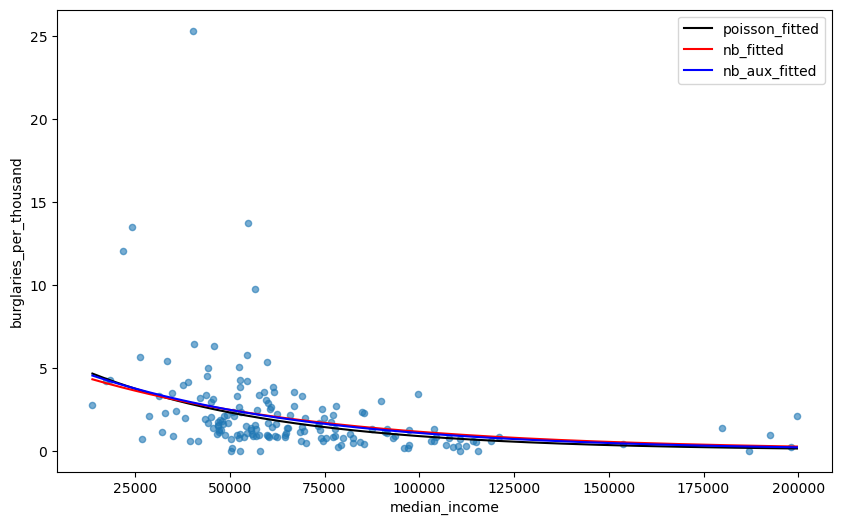

In [39]:
fit_df = pd.DataFrame({
    'median_income': np.linspace(
        start = incidents_by_tract['median_income'].min(),
        stop = incidents_by_tract['median_income'].max(),
        num = 250)
})
fit_df['poisson_fitted'] = poisson_model.predict(fit_df)
fit_df['nb_fitted'] = nb_model.predict(fit_df)
fit_df['nb_aux_fitted'] = nb_model_aux.predict(fit_df)


ax = incidents_by_tract.plot(x = 'median_income',
                     y = 'burglaries_per_thousand',
                     kind = 'scatter',
                     figsize = (10,6),
                     alpha = 0.6)

fit_df.plot(x = 'median_income',
            y = 'poisson_fitted',
            color = 'black',
            ax = ax)

fit_df.plot(x = 'median_income',
            y = 'nb_fitted',
            color = 'red',
            ax = ax)
            
fit_df.plot(x = 'median_income',
            y = 'nb_aux_fitted',
            color = 'blue',
            ax = ax);

Additional Resources for Generalized Linear Models:

- DataCamp - Generalized Linear Models in Python (https://learn.datacamp.com/courses/generalized-linear-models-in-python)
- Beyond Multiple Linear Regression, Chapter 4 (https://bookdown.org/roback/bookdown-BeyondMLR/ch-poissonreg.html) Warning - the code in this book is all R, but the conceptual explanations are very clear.
- This set of notes (https://apwheele.github.io/MathPosts/PoissonReg.html#negative-binomial-when-the-poisson-does-not-fit), which talks about the problem of overdispersion.

## Other Idea: Incorporate Geometric Information

It appears that the closer to the center of the county, the higher the burglaries. Does adding distance help?

In [42]:
center = unary_union(tract_geo['geometry']).centroid

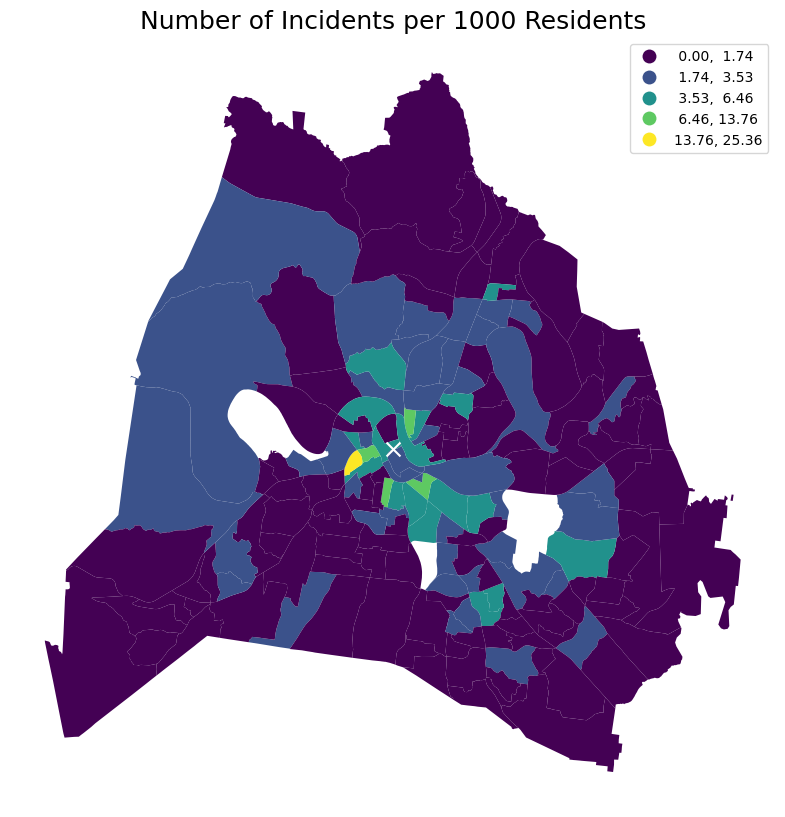

In [43]:
fix, ax = plt.subplots(figsize = (10,10))

(
    pd.merge(left = tract_geo,
             right = (incidents_by_tract
                      .assign(incident_rate = 1000 * incidents_by_tract['num_burglaries'] / incidents_by_tract['population'])
                     )
            )
    .plot(column = 'incident_rate',
          ax = ax,
          scheme = 'NaturalBreaks',
         legend = True)
)

plt.scatter(x = [center.x],
            y = [center.y],
            color = 'white',
            marker = 'x',
            s = 100)
plt.title('Number of Incidents per 1000 Residents', fontsize = 18)
plt.axis('off');

In [44]:
# Stolen from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees) in km.

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [46]:
tract_geo['dist_to_center'] = tract_geo.apply(lambda row: haversine_np(row['geometry'].centroid.x,
                                     row['geometry'].centroid.y,
                                     center.x, center.y), axis = 1)

In [48]:
incidents_by_tract = pd.merge(left = incidents_by_tract,
        right = tract_geo[['TRACTCE', 'dist_to_center']])

In [49]:
poisson_model_dist = smf.glm('num_burglaries ~ I(median_income / 1000) + dist_to_center',
                        offset = np.log(incidents_by_tract['population'] / 1000),
                        family = sm.families.Poisson(),
                        data = incidents_by_tract).fit()

poisson_model_dist.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_burglaries   No. Observations:                  170
Model:                            GLM   Df Residuals:                      167
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -615.31
Date:                Fri, 17 Feb 2023   Deviance:                       639.71
Time:                        16:53:20   Pearson chi2:                     786.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9057
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.1965      0.082     26.770      0.000       2.036       2.357
I(median_income / 1000)    -0.0151      0.001    -11.764      0.000      -0.018      -0.013
dist_to_center             -0.0626      0.005    -11.872      0.000      -0.073      -0.052
===========================================================================================
"""

In [52]:
def dd_test(reduced_model, full_model):
    G2 = -2 * (reduced_model.llf - full_model.llf)
    df = full_model.df_model - reduced_model.df_model
    return chi2.sf(G2, df = df)

In [53]:
dd_test(poisson_model, poisson_model_dist)

4.8514844636335625e-33

In [54]:
nb_model_dist = smf.glm('num_burglaries ~ I(median_income / 1000) + dist_to_center',
                    offset= np.log(incidents_by_tract['population'] / 1000),
                    family=sm.families.NegativeBinomial(),
                    data = incidents_by_tract).fit()

nb_model_dist.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_burglaries   No. Observations:                  170
Model:                            GLM   Df Residuals:                      167
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -509.67
Date:                Fri, 17 Feb 2023   Deviance:                       89.540
Time:                        16:55:24   Pearson chi2:                     96.4
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2693
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.0863      0.236      8.856      0.000       1.625       2.548
I(median_income / 1000)    -0.0116      0.003     -3.993      0.000      -0.017      -0.006
dist_to_center             -0.0660      0.015     -4.506      0.000      -0.095      -0.037
===========================================================================================
"""

In [55]:
dd_test(nb_model, nb_model_dist)

5.40405170703003e-06

## Another Idea: Population Density

Note that the `ALAND` column is measured in square meters.

In [58]:
incidents_by_tract = pd.merge(
    left = incidents_by_tract,
    right = tract_geo[['TRACTCE', 'ALAND']]
)

incidents_by_tract['pop_density'] = incidents_by_tract['population'] / incidents_by_tract['ALAND']

In [59]:
nb_model_dist_pd = smf.glm('num_burglaries ~ I(median_income / 1000) + dist_to_center + pop_density',
                    offset= np.log(incidents_by_tract['population'] / 1000),
                    family=sm.families.NegativeBinomial(),
                    data = incidents_by_tract).fit()

nb_model_dist_pd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_burglaries   No. Observations:                  170
Model:                            GLM   Df Residuals:                      166
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -508.97
Date:                Fri, 17 Feb 2023   Deviance:                       88.127
Time:                        16:56:56   Pearson chi2:                     96.1
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2753
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.3665      0.327      7.234      0.000       1.725       3.008
I(median_income / 1000)    -0.0125      0.003     -4.176      0.000      -0.018      -0.007
dist_to_center             -0.0716      0.015     -4.660      0.000      -0.102      -0.041
pop_density              -133.1457    105.990     -1.256      0.209    -340.883      74.591
===========================================================================================
"""

In [60]:
dd_test(nb_model_dist, nb_model_dist_pd)

0.23451892479996733

Conclusion: After controlling for median income and distance to center, we don't have enough evidence to conlude that population density has a significant inpact on number of burglaries.

many thanks to our instructor Michael to showing us additional steps to better refine the models!